# Read Data

In [3]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('SOL_USDT_futures_data_2020.csv')

# Drop unnecessary columns
df.drop(columns=(['coin','volume','closetime','quotevolume','trades','taker_buy_volume','taker_buy_quote','unused']), inplace=True)

# Display the first few rows of the DataFrame
df

,opentime,openprice,highprice,lowprice,closeprice
0,1600066800000,3.2002,4.9100,3.2002,3.3666
1,1600070400000,3.3663,3.5650,3.3000,3.3298
2,1600074000000,3.3298,3.3567,3.2161,3.2755
3,1600077600000,3.2753,3.3873,3.2500,3.3673
4,1600081200000,3.3686,3.4600,3.3200,3.3799
...,...,...,...,...,...
37649,1735603200000,191.2600,191.9600,189.9000,189.9800
37650,1735606800000,189.9900,190.3600,188.2400,189.1000
37651,1735610400000,189.1000,190.7500,188.7100,190.1900
37652,1735614000000,190.1900,190.6900,189.3900,189.8400


In [28]:
import pandas as pd

def load_and_clean_data(csv_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Drop unnecessary columns
    df.drop(columns=['coin', 'volume', 'closetime', 'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused'], inplace=True)

    # Return the cleaned DataFrame
    return df


In [29]:
df = load_and_clean_data('SOL_USDT_futures_data_2020.csv')
df

,opentime,openprice,highprice,lowprice,closeprice
0,1600066800000,3.2002,4.9100,3.2002,3.3666
1,1600070400000,3.3663,3.5650,3.3000,3.3298
2,1600074000000,3.3298,3.3567,3.2161,3.2755
3,1600077600000,3.2753,3.3873,3.2500,3.3673
4,1600081200000,3.3686,3.4600,3.3200,3.3799
...,...,...,...,...,...
37649,1735603200000,191.2600,191.9600,189.9000,189.9800
37650,1735606800000,189.9900,190.3600,188.2400,189.1000
37651,1735610400000,189.1000,190.7500,188.7100,190.1900
37652,1735614000000,190.1900,190.6900,189.3900,189.8400


# Add Super Trend Indicator

In [5]:
import pandas as pd
import numpy as np
from pandas_ta.overlap import hl2
from pandas_ta.volatility import atr
from pandas_ta.utils import get_offset, verify_series

npNaN = np.nan

def calculate_supertrend(df, high_col='highprice', low_col='lowprice', close_col='closeprice', length=10, multiplier=3.0, offset=0, drop_columns=True, **kwargs):
    """
    Calculate the Supertrend indicator and merge it with the original DataFrame.
    
    Parameters:
        df (DataFrame): Original DataFrame containing the OHLC data.
        high_col (str): Name of the high price column. Default is 'highprice'.
        low_col (str): Name of the low price column. Default is 'lowprice'.
        close_col (str): Name of the close price column. Default is 'closeprice'.
        length (int): Lookback period for ATR calculation. Default is 10.
        multiplier (float): Multiplier for ATR. Default is 3.0.
        offset (int): Number of periods to shift the result. Default is 0.
        drop_columns (bool): Whether to drop intermediate columns. Default is True.
        **kwargs: Additional arguments for handling NaN values (e.g., fillna).
    
    Returns:
        DataFrame: The original DataFrame with Supertrend columns merged.
    """
    # Validate Arguments
    high = verify_series(df[high_col], length)
    low = verify_series(df[low_col], length)
    close = verify_series(df[close_col], length)
    offset = get_offset(offset)

    if high is None or low is None or close is None:
        return df

    m = close.size
    dir_, trend = [1] * m, [0] * m
    long, short = [np.nan] * m, [np.nan] * m

    hl2_ = hl2(high, low)
    matr = multiplier * atr(high, low, close, length)
    upperband = hl2_ + matr
    lowerband = hl2_ - matr

    for i in range(1, m):
        if close.iloc[i] > upperband.iloc[i - 1]:
            dir_[i] = 1
        elif close.iloc[i] < lowerband.iloc[i - 1]:
            dir_[i] = -1
        else:
            dir_[i] = dir_[i - 1]
            if dir_[i] > 0 and lowerband.iloc[i] < lowerband.iloc[i - 1]:
                lowerband.iloc[i] = lowerband.iloc[i - 1]
            if dir_[i] < 0 and upperband.iloc[i] > upperband.iloc[i - 1]:
                upperband.iloc[i] = upperband.iloc[i - 1]

        if dir_[i] > 0:
            trend[i] = long[i] = lowerband.iloc[i]
        else:
            trend[i] = short[i] = upperband.iloc[i]

    _props = f"_{length}_{multiplier}"
    supertrend_df = pd.DataFrame({
        f"SUPERT{_props}": trend,
        f"SUPERTd{_props}": dir_,
        f"SUPERTl{_props}": long,
        f"SUPERTs{_props}": short,
    }, index=close.index)

    # Apply offset if needed
    if offset != 0:
        supertrend_df = supertrend_df.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        supertrend_df.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        supertrend_df.fillna(method=kwargs["fill_method"], inplace=True)

    # Merge with original DataFrame
    result_df = df.join(supertrend_df)

    # Drop unnecessary columns
    if drop_columns:
        result_df.drop(columns=[f"SUPERT{_props}", f"SUPERTd{_props}"], inplace=True)

    return result_df

In [6]:
# Example usage
supertrend_df = calculate_supertrend(df, length=10, multiplier=3.0)
supertrend_df

,opentime,openprice,highprice,lowprice,closeprice,SUPERTl_10_3.0,SUPERTs_10_3.0
0,1600066800000,3.2002,4.9100,3.2002,3.3666,NaN,NaN
1,1600070400000,3.3663,3.5650,3.3000,3.3298,NaN,NaN
2,1600074000000,3.3298,3.3567,3.2161,3.2755,NaN,NaN
3,1600077600000,3.2753,3.3873,3.2500,3.3673,NaN,NaN
4,1600081200000,3.3686,3.4600,3.3200,3.3799,NaN,NaN
...,...,...,...,...,...,...,...
37649,1735603200000,191.2600,191.9600,189.9000,189.9800,187.28879,NaN
37650,1735606800000,189.9900,190.3600,188.2400,189.1000,187.28879,NaN
37651,1735610400000,189.1000,190.7500,188.7100,190.1900,187.28879,NaN
37652,1735614000000,190.1900,190.6900,189.3900,189.8400,187.28879,NaN


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

supertrend_df_sample = supertrend_df.tail(200)
supertrend_df_sample

# Assuming `supertrend_df` is already loaded
# Convert 'opentime' to datetime and set up plotting data
supertrend_df_sample['opentime'] = pd.to_datetime(supertrend_df_sample['opentime'], unit='ms')
supertrend_df_sample['date_num'] = mdates.date2num(supertrend_df_sample['opentime'])

# Prepare OHLC data for candlestick plot
ohlc = supertrend_df_sample[['date_num', 'openprice', 'highprice', 'lowprice', 'closeprice']].dropna().values

# Plot configuration
fig, ax = plt.subplots(figsize=(15, 7))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.title('Candlestick Chart with Supertrend Indicators', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Plot candlestick chart
candlestick_ohlc(ax, ohlc, width=0.02, colorup='dodgerblue', colordown='orangered', alpha=0.8)

# Plot SUPERTl_10_3.0 (green) and SUPERTs_10_3.0 (red)
ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTl_10_3.0'], color='dodgerblue', label='Up Trend')
ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTs_10_3.0'], color='orangered', label='Down Trend')

# Add legend
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


# Add Ichimoku Cloud Indicator

In [9]:
import pandas as pd
import numpy as np

def compute_ichimoku_with_supertrend(supertrend_df, conversion_periods=9, base_periods=26, span_b_periods=52, displacement=26):
    """
    Compute Ichimoku Cloud components and join them with the original supertrend DataFrame.
    
    Parameters:
    - supertrend_df (DataFrame): The input DataFrame with 'highprice', 'lowprice', and 'closeprice' columns.
    - conversion_periods (int): Period for the Conversion Line (Tenkan-sen). Default is 9.
    - base_periods (int): Period for the Base Line (Kijun-sen). Default is 26.
    - span_b_periods (int): Period for Leading Span B (Senkou Span B). Default is 52.
    - displacement (int): Displacement for Leading Spans. Default is 26.
    
    Returns:
    - DataFrame: A DataFrame that combines the original supertrend DataFrame with the computed Ichimoku Cloud components.
    """
    # Helper to calculate the average of the highest high and lowest low
    def donchian(data, period):
        return (data['highprice'].rolling(window=period).max() + 
                data['lowprice'].rolling(window=period).min()) / 2

    # Compute Ichimoku Cloud components
    supertrend_df['conversion_line'] = donchian(supertrend_df, conversion_periods)
    supertrend_df['base_line'] = donchian(supertrend_df, base_periods)
    supertrend_df['leading_span_a'] = ((supertrend_df['conversion_line'] + supertrend_df['base_line']) / 2).shift(displacement)
    supertrend_df['leading_span_b'] = donchian(supertrend_df, span_b_periods).shift(displacement)
    supertrend_df['lagging_span'] = supertrend_df['closeprice'].shift(-displacement)
    
    # Drop unnecessary columns
    supertrend_df.drop(columns=['conversion_line', 'base_line', 'lagging_span'], inplace=True)
    
    return supertrend_df

In [10]:
# Usage example:
supertrend_ichimoku_df = compute_ichimoku_with_supertrend(supertrend_df)
supertrend_ichimoku_df

,opentime,openprice,highprice,lowprice,closeprice,SUPERTl_10_3.0,SUPERTs_10_3.0,leading_span_a,leading_span_b
0,1600066800000,3.2002,4.9100,3.2002,3.3666,NaN,NaN,NaN,NaN
1,1600070400000,3.3663,3.5650,3.3000,3.3298,NaN,NaN,NaN,NaN
2,1600074000000,3.3298,3.3567,3.2161,3.2755,NaN,NaN,NaN,NaN
3,1600077600000,3.2753,3.3873,3.2500,3.3673,NaN,NaN,NaN,NaN
4,1600081200000,3.3686,3.4600,3.3200,3.3799,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
37649,1735603200000,191.2600,191.9600,189.9000,189.9800,187.28879,NaN,193.3400,190.39
37650,1735606800000,189.9900,190.3600,188.2400,189.1000,187.28879,NaN,192.6150,190.39
37651,1735610400000,189.1000,190.7500,188.7100,190.1900,187.28879,NaN,192.5175,190.39
37652,1735614000000,190.1900,190.6900,189.3900,189.8400,187.28879,NaN,192.2625,190.39


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from mplfinance.original_flavor import candlestick_ohlc
# import matplotlib.dates as mdates

# supertrend_ichimoku_df_sample = supertrend_ichimoku_df.tail(200)

# # Assuming `supertrend_ichimoku_df_sample` is already loaded
# # Convert 'opentime' to datetime and set up plotting data
# supertrend_ichimoku_df_sample['opentime'] = pd.to_datetime(supertrend_ichimoku_df_sample['opentime'], unit='ms')
# supertrend_ichimoku_df_sample['date_num'] = mdates.date2num(supertrend_ichimoku_df_sample['opentime'])

# # Prepare OHLC data for candlestick plot
# ohlc = supertrend_ichimoku_df_sample[['date_num', 'openprice', 'highprice', 'lowprice', 'closeprice']].dropna().values

# # Plot configuration
# fig, ax = plt.subplots(figsize=(15, 7))
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.xticks(rotation=45)
# plt.title('Candlestick Chart with Supertrend and Ichimoku Leading Spans', fontsize=16)
# plt.xlabel('Date', fontsize=12)
# plt.ylabel('Price', fontsize=12)

# # Plot candlestick chart
# candlestick_ohlc(ax, ohlc, width=0.02, colorup='dodgerblue', colordown='orangered', alpha=0.8)

# # Plot Supertrend Uptrend and Downtrend
# ax.plot(supertrend_ichimoku_df_sample['date_num'], supertrend_ichimoku_df_sample['SUPERTl_10_3.0'], color='blue', label='Up Trend')
# ax.plot(supertrend_ichimoku_df_sample['date_num'], supertrend_ichimoku_df_sample['SUPERTs_10_3.0'], color='red', label='Down Trend')

# # Plot Leading Span A and Leading Span B
# ax.plot(supertrend_ichimoku_df_sample['date_num'], supertrend_ichimoku_df_sample['leading_span_a'], color='green', linestyle='--', label='Leading Span A')
# ax.plot(supertrend_ichimoku_df_sample['date_num'], supertrend_ichimoku_df_sample['leading_span_b'], color='red', linestyle='--', label='Leading Span B')

# # Add legend
# plt.legend(loc='upper left', fontsize=12)
# plt.tight_layout()
# plt.show()

# Backtest Signaling

In [11]:
df_backtest = supertrend_ichimoku_df.copy()

# Rename the last 4 columns
new_column_names = {
    'opentime': 'time',
    'openprice': 'open',
    'highprice': 'high',
    'lowprice': 'low',
    'closeprice': 'close',
    'SUPERTl_10_3.0': 'Up Trend',
    'SUPERTs_10_3.0': 'Down Trend',
    'leading_span_a': 'Leading Span A',
    'leading_span_b': 'Leading Span B',
}
df_backtest.rename(columns=new_column_names, inplace=True)

# Drop rows 0 to 50 becuase the cloud has a 50 row lags
df_backtest.drop(index=range(51), inplace=True)

df_backtest.reset_index(drop=True,inplace=True)

df_backtest

,time,open,high,low,close,Up Trend,Down Trend,Leading Span A,Leading Span B
0,1600250400000,2.6703,2.6820,2.5627,2.5627,NaN,2.953512,3.621450,NaN
1,1600254000000,2.5627,2.6378,2.5102,2.5870,NaN,2.910347,3.285200,NaN
2,1600257600000,2.5811,2.6186,2.5616,2.5720,NaN,2.909850,3.266450,NaN
3,1600261200000,2.5723,2.5832,2.5414,2.5564,NaN,2.862549,3.260875,NaN
4,1600264800000,2.5525,2.5759,2.4316,2.4550,NaN,2.817305,3.263725,NaN
...,...,...,...,...,...,...,...,...,...
37598,1735603200000,191.2600,191.9600,189.9000,189.9800,187.28879,NaN,193.340000,190.39
37599,1735606800000,189.9900,190.3600,188.2400,189.1000,187.28879,NaN,192.615000,190.39
37600,1735610400000,189.1000,190.7500,188.7100,190.1900,187.28879,NaN,192.517500,190.39
37601,1735614000000,190.1900,190.6900,189.3900,189.8400,187.28879,NaN,192.262500,190.39


In [12]:
import numpy as np

# Set 'super_trend' to 1 if 'Down Trend' is NaN, and to 0 if 'Up Trend' is NaN
df_backtest['super_trend'] = np.where(df_backtest['Down Trend'].isna(), 1, 
                                      np.where(df_backtest['Up Trend'].isna(), -1, np.nan))

# Define a function to determine the action suggestion for each row
def determine_criteria_pass(row):
    if row['super_trend'] == 1 and row['open'] > max(row['Leading Span A'], row['Leading Span B']):
        return 1
    elif row['super_trend'] == -1 and row['open'] < min(row['Leading Span A'], row['Leading Span B']):
        return 1
    return 0

# Apply the function row-wise to the DataFrame
df_backtest['criteria'] = df_backtest.apply(determine_criteria_pass, axis=1)

# Initialize 'action' column to None
df_backtest['action'] = None

# Assign 'long' where super_trend == 1 and criteria == 1
df_backtest['action'] = np.where(
    (df_backtest['super_trend'] == 1) & (df_backtest['criteria'] == 1),
    'long',
    df_backtest['action']
)

# Assign 'short' where super_trend == -1 and criteria == 1
df_backtest['action'] = np.where(
    (df_backtest['super_trend'] == -1) & (df_backtest['criteria'] == 1),
    'short',
    df_backtest['action']
)

# Assign 'close' where super_trend changes (shifted value not equal to current value)
df_backtest['trend_change'] = np.where(
    df_backtest['super_trend'].shift(1) != df_backtest['super_trend'],
    1,
    0
)

df_backtest['time'] = (df_backtest['time']/1000).astype(int)

df_backtest

,time,open,high,low,close,Up Trend,Down Trend,Leading Span A,Leading Span B,super_trend,criteria,action,trend_change
0,1600250400,2.6703,2.6820,2.5627,2.5627,NaN,2.953512,3.621450,NaN,-1.0,1,short,1
1,1600254000,2.5627,2.6378,2.5102,2.5870,NaN,2.910347,3.285200,NaN,-1.0,1,short,0
2,1600257600,2.5811,2.6186,2.5616,2.5720,NaN,2.909850,3.266450,NaN,-1.0,1,short,0
3,1600261200,2.5723,2.5832,2.5414,2.5564,NaN,2.862549,3.260875,NaN,-1.0,1,short,0
4,1600264800,2.5525,2.5759,2.4316,2.4550,NaN,2.817305,3.263725,NaN,-1.0,1,short,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37598,1735603200,191.2600,191.9600,189.9000,189.9800,187.28879,NaN,193.340000,190.39,1.0,0,None,0
37599,1735606800,189.9900,190.3600,188.2400,189.1000,187.28879,NaN,192.615000,190.39,1.0,0,None,0
37600,1735610400,189.1000,190.7500,188.7100,190.1900,187.28879,NaN,192.517500,190.39,1.0,0,None,0
37601,1735614000,190.1900,190.6900,189.3900,189.8400,187.28879,NaN,192.262500,190.39,1.0,0,None,0


In [13]:
# Get the backtest trade history
df_action_close = df_backtest[df_backtest['trend_change'] == 1]

# Generate consecutive row index pairs
index_list = df_action_close.index.tolist()
consecutive_pairs = [(index_list[i], index_list[i + 1]) for i in range(len(index_list) - 1)]

consecutive_pairs

# Create a function to process each pair
def process_consecutive_pairs(df_backtest, consecutive_pairs):
    result_pairs = []

    for start_idx, end_idx in consecutive_pairs:
        # Slice the dataframe between the two indices (inclusive)
        sub_df = df_backtest.iloc[start_idx:end_idx+1]
        
        # Check if there is any "short" or "long" action in the 'action' column
        actions = sub_df['action']
        long_short_indices = actions[actions.isin(['long', 'short'])]

        if not long_short_indices.empty:
            # Note the first occurrence nearest to the first index of the pair
            first_action_idx = long_short_indices.index[0]
            # Add the result as a tuple (first action index, second close index)
            result_pairs.append((first_action_idx, end_idx))

    return result_pairs

# Call the function with your DataFrame and consecutive_pairs
result = process_consecutive_pairs(df_backtest, consecutive_pairs)

# Function to drop pairs where both indices are the same
def remove_duplicate_indices(pairs):
    return [(start_idx, end_idx) for start_idx, end_idx in pairs if start_idx != end_idx]

# Apply the function to the result list
filtered_result = remove_duplicate_indices(result)

# Create the result DataFrame
results = []
for start_idx, end_idx in filtered_result:
    position = df_backtest.loc[start_idx, 'action']
    open_time = df_backtest.loc[start_idx, 'time']
    open_price = df_backtest.loc[start_idx, 'open']
    exit_time = df_backtest.loc[end_idx, 'time']
    exit_price = df_backtest.loc[end_idx, 'close']
    
    # Slice the DataFrame between start_idx and end_idx (inclusive)
    sub_df = df_backtest.iloc[start_idx:end_idx + 1]
    min_price = sub_df['low'].min()
    max_price = sub_df['high'].max()
    
    results.append({
        "position": position,
        "open_time": open_time,
        "open_price": open_price,
        "exit_time": exit_time,
        "exit_price": exit_price,
        "min_price": min_price,
        "max_price": max_price
    })

backtest_trade_recap = pd.DataFrame(results)

# Display the recap DataFrame
backtest_trade_recap

,position,open_time,open_price,exit_time,exit_price,min_price,max_price
0,short,1600250400,2.6703,1600365600,2.7405,2.3569,2.7728
1,long,1600380000,2.9248,1600610400,2.8008,2.7240,3.2509
2,short,1600614000,2.8010,1600657200,2.9924,2.6876,3.0197
3,short,1600671600,2.8670,1600740000,2.9500,2.4576,2.9500
4,long,1600779600,2.8628,1601020800,2.9416,2.6863,3.2538
...,...,...,...,...,...,...,...
737,short,1734786000,187.0700,1734984000,191.1000,176.3600,191.6600
738,long,1734987600,191.1000,1735196400,193.3800,186.0500,201.7700
739,short,1735203600,189.0700,1735401600,192.5300,182.6600,194.2900
740,long,1735405200,192.5300,1735506000,190.7100,190.2100,197.6800


In [21]:
import numpy as np
import pandas as pd

def generate_backtest_trade_recap(df):
    # Step 1: Rename columns
    new_column_names = {
        'opentime': 'time',
        'openprice': 'open',
        'highprice': 'high',
        'lowprice': 'low',
        'closeprice': 'close',
        'SUPERTl_10_3.0': 'Up Trend',
        'SUPERTs_10_3.0': 'Down Trend',
        'leading_span_a': 'Leading Span A',
        'leading_span_b': 'Leading Span B',
    }
    df.rename(columns=new_column_names, inplace=True)

    # Step 2: Drop rows 0 to 50
    df.drop(index=range(51), inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Step 3: Set 'super_trend'
    df['super_trend'] = np.where(df['Down Trend'].isna(), 1, 
                                 np.where(df['Up Trend'].isna(), -1, np.nan))

    # Step 4: Define criteria
    def determine_criteria_pass(row):
        if row['super_trend'] == 1 and row['open'] > max(row['Leading Span A'], row['Leading Span B']):
            return 1
        elif row['super_trend'] == -1 and row['open'] < min(row['Leading Span A'], row['Leading Span B']):
            return 1
        return 0

    df['criteria'] = df.apply(determine_criteria_pass, axis=1)

    # Step 5: Assign actions
    df['action'] = None
    df['action'] = np.where((df['super_trend'] == 1) & (df['criteria'] == 1), 'long', df['action'])
    df['action'] = np.where((df['super_trend'] == -1) & (df['criteria'] == 1), 'short', df['action'])

    # Step 6: Identify trend changes
    df['trend_change'] = np.where(df['super_trend'].shift(1) != df['super_trend'], 1, 0)
    df['time'] = (df['time'] / 1000).astype(int)

    # Step 7: Filter trade history
    df_action_close = df[df['trend_change'] == 1]
    index_list = df_action_close.index.tolist()
    consecutive_pairs = [(index_list[i], index_list[i + 1]) for i in range(len(index_list) - 1)]

    # Step 8: Process pairs
    def process_consecutive_pairs(df, pairs):
        result_pairs = []
        for start_idx, end_idx in pairs:
            sub_df = df.iloc[start_idx:end_idx + 1]
            actions = sub_df['action']
            long_short_indices = actions[actions.isin(['long', 'short'])]
            if not long_short_indices.empty:
                first_action_idx = long_short_indices.index[0]
                result_pairs.append((first_action_idx, end_idx))
        return result_pairs

    result = process_consecutive_pairs(df, consecutive_pairs)

    # Step 9: Remove duplicate indices
    filtered_result = [(start_idx, end_idx) for start_idx, end_idx in result if start_idx != end_idx]

    # Step 10: Generate recap DataFrame
    results = []
    for start_idx, end_idx in filtered_result:
        position = df.loc[start_idx, 'action']
        open_time = df.loc[start_idx, 'time']
        open_price = df.loc[start_idx, 'open']
        exit_time = df.loc[end_idx, 'time']
        exit_price = df.loc[end_idx, 'close']

        sub_df = df.iloc[start_idx:end_idx + 1]
        min_price = sub_df['low'].min()
        max_price = sub_df['high'].max()

        results.append({
            "position": position,
            "open_time": open_time,
            "open_price": open_price,
            "exit_time": exit_time,
            "exit_price": exit_price,
            "min_price": min_price,
            "max_price": max_price
        })

    return pd.DataFrame(results)

In [22]:
backtest_trade_recap = generate_backtest_trade_recap(supertrend_ichimoku_df)
backtest_trade_recap

,position,open_time,open_price,exit_time,exit_price,min_price,max_price
0,short,1600250400,2.6703,1600365600,2.7405,2.3569,2.7728
1,long,1600380000,2.9248,1600610400,2.8008,2.7240,3.2509
2,short,1600614000,2.8010,1600657200,2.9924,2.6876,3.0197
3,short,1600671600,2.8670,1600740000,2.9500,2.4576,2.9500
4,long,1600779600,2.8628,1601020800,2.9416,2.6863,3.2538
...,...,...,...,...,...,...,...
737,short,1734786000,187.0700,1734984000,191.1000,176.3600,191.6600
738,long,1734987600,191.1000,1735196400,193.3800,186.0500,201.7700
739,short,1735203600,189.0700,1735401600,192.5300,182.6600,194.2900
740,long,1735405200,192.5300,1735506000,190.7100,190.2100,197.6800


# Back Test Simulation

In [ ]:
import numpy as np
import pandas as pd

# Copy the backtest_trade_recap DataFrame
backtest_trade_sim = backtest_trade_recap.copy()

# Initialize columns
backtest_trade_sim['quantity'] = 1000  # Base quantity per trade
backtest_trade_sim['leverage'] = 1    # Default leverage (e.g., 10x)
backtest_trade_sim['open_fee'] = 0
backtest_trade_sim['exit_fee'] = 0
backtest_trade_sim['realized_pnl'] = 0
backtest_trade_sim['max_drawdown_percent'] = 0  # Column for max drawdown % calculation

# Define the taker fee and funding rate
taker_fee = 0.0005  # 0.05% futures
funding_rate = 0.0001  # 0.01%

# Adjust quantity based on leverage
backtest_trade_sim['leveraged_quantity'] = backtest_trade_sim['quantity'] * backtest_trade_sim['leverage']

# Calculate open_fee
backtest_trade_sim['open_fee'] = backtest_trade_sim['leveraged_quantity'] * taker_fee

# Calculate exit_fee
backtest_trade_sim['exit_fee'] = (
    (backtest_trade_sim['leveraged_quantity'] / backtest_trade_sim['open_price']) * 
    backtest_trade_sim['exit_price'] * taker_fee
)

# Calculate position hold time
backtest_trade_sim['hold_time'] = (backtest_trade_sim['exit_time'] - backtest_trade_sim['open_time']) / 3600

# Calculate funding_fee occurrences and total funding_fee
backtest_trade_sim['funding_fee_occurence'] = backtest_trade_sim['hold_time'] // 8
backtest_trade_sim['funding_fee'] = (
    backtest_trade_sim['leveraged_quantity'] * backtest_trade_sim['funding_fee_occurence'] * funding_rate
)

# Calculate max drawdown (in %), accounting for leverage
def calculate_max_drawdown(row):
    if row['position'] == 'long':
        # For Long, calculate max drawdown from open price to min price
        max_drawdown = (row['min_price'] - row['open_price']) / row['open_price'] * 100
    elif row['position'] == 'short':
        # For Short, calculate max drawdown from open price to max price
        max_drawdown = (row['open_price'] - row['max_price']) / row['open_price'] * 100
    else:
        return 0  # Default case, should not be reached
    
    # Include leverage to magnify the effect of drawdown
    max_drawdown_leverage = max_drawdown * row['leverage']  # Leverage magnifies the drawdown
    
    return max_drawdown_leverage

backtest_trade_sim['max_drawdown_percent'] = backtest_trade_sim.apply(calculate_max_drawdown, axis=1)

# Calculate realized_pnl
def calculate_realized_pnl(row):
    position = row['position']
    leveraged_quantity = row['leveraged_quantity']
    open_price = row['open_price']
    exit_price = row['exit_price']
    open_fee = row['open_fee']
    exit_fee = row['exit_fee']
    funding_fee = row['funding_fee']
    
    if position == 'short':
        return leveraged_quantity - (leveraged_quantity / open_price * exit_price) - open_fee - exit_fee - funding_fee
    elif position == 'long':
        return (leveraged_quantity / open_price * exit_price) - leveraged_quantity - open_fee - exit_fee - funding_fee
    return 0  # Default case, should not be reached

backtest_trade_sim['realized_pnl'] = backtest_trade_sim.apply(calculate_realized_pnl, axis=1)

# Calculate cumulative realized profit and loss
backtest_trade_sim['cumulative_realized_pnl'] = backtest_trade_sim['realized_pnl'].cumsum()

# Define trade win/loss
backtest_trade_sim['win_loss'] = np.where(backtest_trade_sim['realized_pnl'] >= 0, 'Win', 'Lose')

# Display specific columns
backtest_trade_sim[['position', 'open_time', 'open_price', 'exit_time', 'exit_price', 'min_price', 'max_price', 
                          'realized_pnl', 'max_drawdown_percent', 'leveraged_quantity', 'cumulative_realized_pnl', 'win_loss']]

,position,open_time,open_price,exit_time,exit_price,min_price,max_price,realized_pnl,max_drawdown_percent,leveraged_quantity,cumulative_realized_pnl,win_loss
0,short,1600250400,2.6703,1600365600,2.7405,2.3569,2.7728,-27.702326,-3.838520,1000,-27.702326,Lose
1,long,1600380000,2.9248,1600610400,2.8008,2.7240,3.2509,-44.174863,-6.865427,1000,-71.877189,Lose
2,short,1600614000,2.8010,1600657200,2.9924,2.6876,3.0197,-69.466905,-7.807926,1000,-141.344093,Lose
3,short,1600671600,2.8670,1600740000,2.9500,2.4576,2.9500,-30.164597,-2.895012,1000,-171.508691,Lose
4,long,1600779600,2.8628,1601020800,2.9416,2.6863,3.2538,25.711737,-6.165293,1000,-145.796954,Win
...,...,...,...,...,...,...,...,...,...,...,...,...
737,short,1734786000,187.0700,1734984000,191.1000,176.3600,191.6600,-23.153509,-2.453627,1000,5712.492378,Lose
738,long,1734987600,191.1000,1735196400,193.3800,186.0500,201.7700,10.224961,-2.642595,1000,5722.717338,Win
739,short,1735203600,189.0700,1735401600,192.5300,182.6600,194.2900,-19.909251,-2.760882,1000,5702.808088,Lose
740,long,1735405200,192.5300,1735506000,190.7100,190.2100,197.6800,-10.748346,-1.205007,1000,5692.059742,Lose


## Static Balance

In [15]:
# Calculate trade simulation
backtest_trade_sim = backtest_trade_recap.copy()

backtest_trade_sim['balance'] = 1000
backtest_trade_sim['open_fee'] = 0
backtest_trade_sim['exit_fee'] = 0
backtest_trade_sim['realized_pnl'] = 0

# Define the taker fee (e.g., 0.001 for 0.1%)
taker_fee = 0.0005 # 0.05% futures
# taker_fee = 0.001 # 0.1% spot

# Define Funding rate
funding_rate = 0.0001 #0.01%

# Calculate open_fee
backtest_trade_sim['open_fee'] = backtest_trade_sim['balance'] * taker_fee

# Calculate exit_fee
backtest_trade_sim['exit_fee'] = (
    (backtest_trade_sim['balance'] / backtest_trade_sim['open_price']) * 
    backtest_trade_sim['exit_price'] * taker_fee
)

# Calculate position hold time
backtest_trade_sim['hold_time'] = (backtest_trade_sim['exit_time'] - backtest_trade_sim['open_time']) / 3600

# Calculate how many times it need to pay funding_fee
backtest_trade_sim['funding_fee_occurence'] = backtest_trade_sim['hold_time'] // 8

# Calculate funding_fee
backtest_trade_sim['funding_fee'] = backtest_trade_sim['balance'] * backtest_trade_sim['funding_fee_occurence'] * funding_rate

# Calculate realized_pnl
def calculate_realized_pnl(row):
    position = row['position']
    balance = row['balance']
    open_price = row['open_price']
    exit_price = row['exit_price']
    open_fee = row['open_fee']
    exit_fee = row['exit_fee']
    funding_fee = row['funding_fee']
    
    if position == 'short':
        return balance - (balance / open_price * exit_price) - open_fee - exit_fee - funding_fee
    elif position == 'long':
        return (balance / open_price * exit_price) - balance - open_fee - exit_fee - funding_fee
    return 0  # Default case, should not be reached

backtest_trade_sim['realized_pnl'] = backtest_trade_sim.apply(calculate_realized_pnl, axis=1)

# Calculate cumulative realized profit and loss
backtest_trade_sim['cumulative_realized_pnl'] = backtest_trade_sim['realized_pnl'].cumsum()

# Define trade win/loss
backtest_trade_sim['win_loss'] = np.where(backtest_trade_sim['realized_pnl'] >= 0, 'Win', 'Lose')

# Display the updated DataFrame
backtest_trade_sim

,position,open_time,open_price,exit_time,exit_price,min_price,max_price,balance,open_fee,exit_fee,realized_pnl,hold_time,funding_fee_occurence,funding_fee,cumulative_realized_pnl,win_loss
0,short,1600250400,2.6703,1600365600,2.7405,2.3569,2.7728,1000,0.5,0.513145,-27.702326,32.0,4.0,0.4,-27.702326,Lose
1,long,1600380000,2.9248,1600610400,2.8008,2.7240,3.2509,1000,0.5,0.478802,-44.174863,64.0,8.0,0.8,-71.877189,Lose
2,short,1600614000,2.8010,1600657200,2.9924,2.6876,3.0197,1000,0.5,0.534166,-69.466905,12.0,1.0,0.1,-141.344093,Lose
3,short,1600671600,2.8670,1600740000,2.9500,2.4576,2.9500,1000,0.5,0.514475,-30.164597,19.0,2.0,0.2,-171.508691,Lose
4,long,1600779600,2.8628,1601020800,2.9416,2.6863,3.2538,1000,0.5,0.513763,25.711737,67.0,8.0,0.8,-145.796954,Win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,short,1734786000,187.0700,1734984000,191.1000,176.3600,191.6600,1000,0.5,0.510771,-23.153509,55.0,6.0,0.6,5712.492378,Lose
738,long,1734987600,191.1000,1735196400,193.3800,186.0500,201.7700,1000,0.5,0.505965,10.224961,58.0,7.0,0.7,5722.717338,Win
739,short,1735203600,189.0700,1735401600,192.5300,182.6600,194.2900,1000,0.5,0.509150,-19.909251,55.0,6.0,0.6,5702.808088,Lose
740,long,1735405200,192.5300,1735506000,190.7100,190.2100,197.6800,1000,0.5,0.495273,-10.748346,28.0,3.0,0.3,5692.059742,Lose


In [16]:
import pandas as pd

# Count of positions (number and percentage)
position_counts = backtest_trade_sim['position'].value_counts()
position_percentages = position_counts / len(backtest_trade_sim) * 100

# Realized PnL statistics
realized_pnl_stats = {
    'max': backtest_trade_sim['realized_pnl'].max(),
    'min': backtest_trade_sim['realized_pnl'].min(),
    'avg': backtest_trade_sim['realized_pnl'].mean(),
    'median': backtest_trade_sim['realized_pnl'].median(),
}

# Win rate (overall)
total_trades = len(backtest_trade_sim)
wins = (backtest_trade_sim['realized_pnl'] >= 0).sum()
win_rate = wins / total_trades * 100

# Win rate per position (long/short)
win_rate_by_position = (
    backtest_trade_sim.groupby('position')['realized_pnl']
    .apply(lambda x: (x >= 0).sum() / len(x) * 100)
)

# Results
results = {
    "Position Counts": position_counts.to_dict(),
    "Position Percentages": position_percentages.to_dict(),
    "Realized PnL Stats": realized_pnl_stats,
    "Overall Win Rate": win_rate,
    "Win Rate by Position": win_rate_by_position.to_dict(),
}

# Display results
results

{'Position Counts': {'long': 374, 'short': 368},
 'Position Percentages': {'long': 50.40431266846361,
  'short': 49.59568733153639},
 'Realized PnL Stats': {'max': np.float64(570.0567589659752),
  'min': np.float64(-244.53475186096532),
  'avg': np.float64(7.61916696094326),
  'median': np.float64(-12.702172119688054)},
 'Overall Win Rate': np.float64(40.700808625336926),
 'Win Rate by Position': {'long': 42.24598930481284,
  'short': 39.130434782608695}}

In [81]:
import pandas as pd
import numpy as np

def backtest_trade_summary(backtest_trade_recap, taker_fee=0.0005, funding_rate=0.0001):
    backtest_trade_sim = backtest_trade_recap.copy()

    # Initialize columns
    backtest_trade_sim['balance'] = 1000
    backtest_trade_sim['open_fee'] = 0
    backtest_trade_sim['exit_fee'] = 0
    backtest_trade_sim['realized_pnl'] = 0

    # Calculate open_fee
    backtest_trade_sim['open_fee'] = backtest_trade_sim['balance'] * taker_fee

    # Calculate exit_fee
    backtest_trade_sim['exit_fee'] = (
        (backtest_trade_sim['balance'] / backtest_trade_sim['open_price']) * 
        backtest_trade_sim['exit_price'] * taker_fee
    )

    # Calculate position hold time in hours
    backtest_trade_sim['hold_time'] = (backtest_trade_sim['exit_time'] - backtest_trade_sim['open_time']) / 3600

    # Calculate how many times funding fee occurs
    backtest_trade_sim['funding_fee_occurence'] = backtest_trade_sim['hold_time'] // 8

    # Calculate funding_fee
    backtest_trade_sim['funding_fee'] = backtest_trade_sim['balance'] * backtest_trade_sim['funding_fee_occurence'] * funding_rate

    # Function to calculate realized PnL
    def calculate_realized_pnl(row):
        position = row['position']
        balance = row['balance']
        open_price = row['open_price']
        exit_price = row['exit_price']
        open_fee = row['open_fee']
        exit_fee = row['exit_fee']
        funding_fee = row['funding_fee']

        if position == 'short':
            return balance - (balance / open_price * exit_price) - open_fee - exit_fee - funding_fee
        elif position == 'long':
            return (balance / open_price * exit_price) - balance - open_fee - exit_fee - funding_fee
        return 0  # Default case, should not be reached

    # Calculate realized PnL for each trade
    backtest_trade_sim['realized_pnl'] = backtest_trade_sim.apply(calculate_realized_pnl, axis=1)

    # Calculate cumulative realized profit and loss
    backtest_trade_sim['cumulative_realized_pnl'] = backtest_trade_sim['realized_pnl'].cumsum()

    # Define trade win/loss
    backtest_trade_sim['win_loss'] = np.where(backtest_trade_sim['realized_pnl'] >= 0, 'Win', 'Lose')

    # Count of positions (number and percentage)
    position_counts = backtest_trade_sim['position'].value_counts()
    position_percentages = position_counts / len(backtest_trade_sim) * 100

    # Realized PnL statistics
    realized_pnl_stats = {
        'max': backtest_trade_sim['realized_pnl'].max(),
        'min': backtest_trade_sim['realized_pnl'].min(),
        'avg': backtest_trade_sim['realized_pnl'].mean(),
        'median': backtest_trade_sim['realized_pnl'].median(),
    }

    # Hold time statistics
    hold_time_stats = {
        'max': backtest_trade_sim['hold_time'].max(),
        'min': backtest_trade_sim['hold_time'].min(),
        'avg': backtest_trade_sim['hold_time'].mean(),
        'median': backtest_trade_sim['hold_time'].median(),
    }

    # Win rate (overall)
    total_trades = len(backtest_trade_sim)
    wins = (backtest_trade_sim['realized_pnl'] >= 0).sum()
    win_rate = wins / total_trades * 100

    # Win rate per position (long/short)
    win_rate_by_position = (
        backtest_trade_sim.groupby('position')['realized_pnl']
        .apply(lambda x: (x >= 0).sum() / len(x) * 100)
    )

    # Results dictionary
    results = {
        "Position Counts": position_counts.to_dict(),
        "Position Percentages": position_percentages.to_dict(),
        "Realized PnL Stats": realized_pnl_stats,
        "Hold Time Stats": hold_time_stats,  # Add hold time stats
        "Overall Win Rate": win_rate,
        "Win Rate by Position": win_rate_by_position.to_dict(),
    }

    # Latest row of the cumulative PnL
    latest_cumulative_pnl = backtest_trade_sim['cumulative_realized_pnl'].iloc[-1]
    results['Cummulative_PnL'] = latest_cumulative_pnl

    # Calculate total count of long and short trades combined
    total_long_short_count = len(backtest_trade_sim)

    # Add total long/short trades count to results
    results['Total Long + Short Trades'] = total_long_short_count  # Total count of trades

    return backtest_trade_sim, results

In [82]:
backtest_trade_sim, results = backtest_trade_summary(backtest_trade_recap)
results

{'Position Counts': {'long': 179, 'short': 172},
 'Position Percentages': {'long': 50.997150997150996,
  'short': 49.002849002849004},
 'Realized PnL Stats': {'max': np.float64(1373.7000045660016),
  'min': np.float64(-343.41025319343066),
  'avg': np.float64(19.52251146781956),
  'median': np.float64(-14.057862539969754)},
 'Hold Time Stats': {'max': np.float64(696.0),
  'min': np.float64(4.0),
  'avg': np.float64(92.5925925925926),
  'median': np.float64(72.0)},
 'Overall Win Rate': np.float64(42.16524216524217),
 'Win Rate by Position': {'long': 45.2513966480447,
  'short': 38.95348837209303},
 'Cummulative_PnL': np.float64(6852.401525204663),
 'Total Long + Short Trades': 351}

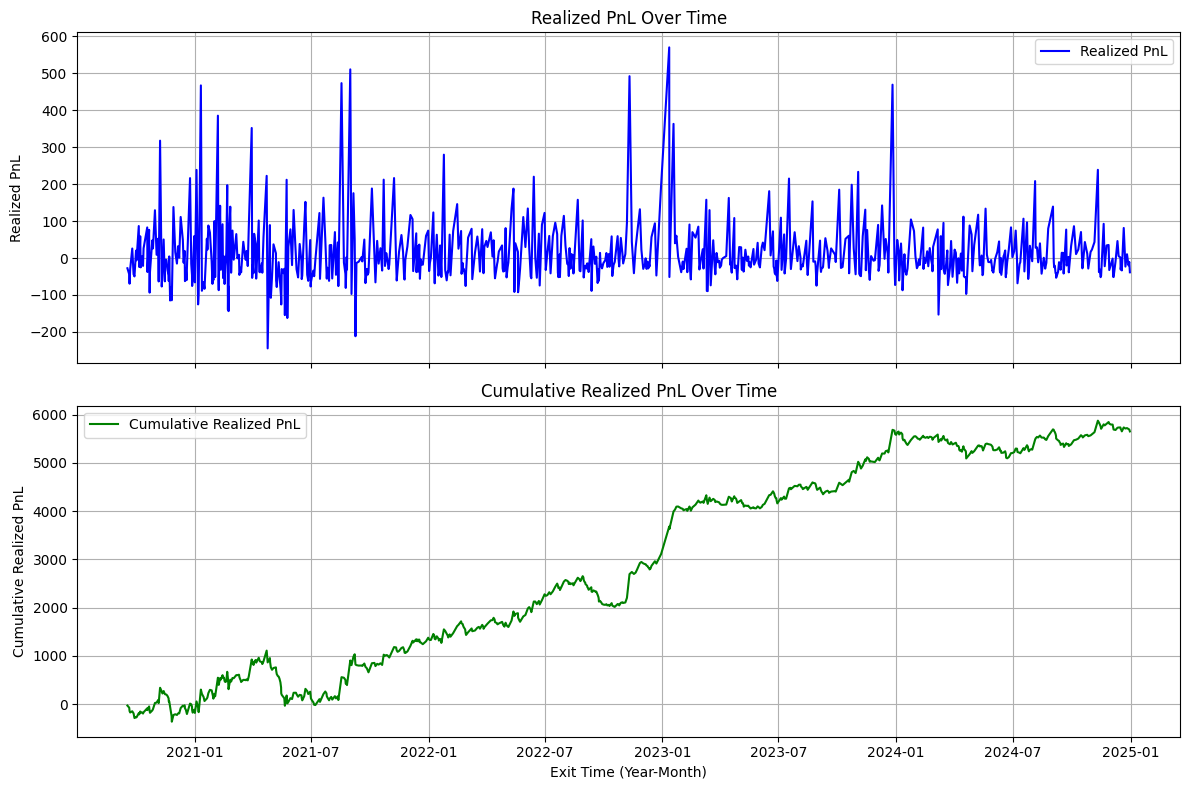

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

backtest_trade_sim_plot = backtest_trade_sim.copy()

# Convert exit_time from UNIX milliseconds to UTC+0 datetime
backtest_trade_sim_plot['exit_time_utc'] = pd.to_datetime(
    backtest_trade_sim_plot['exit_time'], unit='s', utc=True
)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Realized PnL vs Exit Time
ax[0].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['realized_pnl'], label='Realized PnL', color='blue')
ax[0].set_title('Realized PnL Over Time')
ax[0].set_ylabel('Realized PnL')

# Cumulative Realized PnL vs Exit Time
ax[1].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['cumulative_realized_pnl'], label='Cumulative Realized PnL', color='green')
ax[1].set_title('Cumulative Realized PnL Over Time')
ax[1].set_ylabel('Cumulative Realized PnL')

# Format x-axis to show year and month
ax[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
ax[1].set_xlabel('Exit Time (Year-Month)')

# Improve layout and add gridlines
for axis in ax:
    axis.grid(True)
    axis.legend()

plt.tight_layout()
plt.show()

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def plot_realized_pnl(backtest_trade_sim):
    backtest_trade_sim_plot = backtest_trade_sim.copy()

    # Convert exit_time from UNIX milliseconds to UTC+0 datetime
    backtest_trade_sim_plot['exit_time_utc'] = pd.to_datetime(
        backtest_trade_sim_plot['exit_time'], unit='s', utc=True
    )

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Realized PnL vs Exit Time
    ax[0].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['realized_pnl'], label='Realized PnL', color='blue')
    ax[0].set_title('Realized PnL Over Time')
    ax[0].set_ylabel('Realized PnL')

    # Cumulative Realized PnL vs Exit Time
    ax[1].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['cumulative_realized_pnl'], label='Cumulative Realized PnL', color='green')
    ax[1].set_title('Cumulative Realized PnL Over Time')
    ax[1].set_ylabel('Cumulative Realized PnL')

    # Format x-axis to show year and month
    ax[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    ax[1].set_xlabel('Exit Time (Year-Month)')

    # Improve layout and add gridlines
    for axis in ax:
        axis.grid(True)
        axis.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_realized_pnl(backtest_trade_sim)

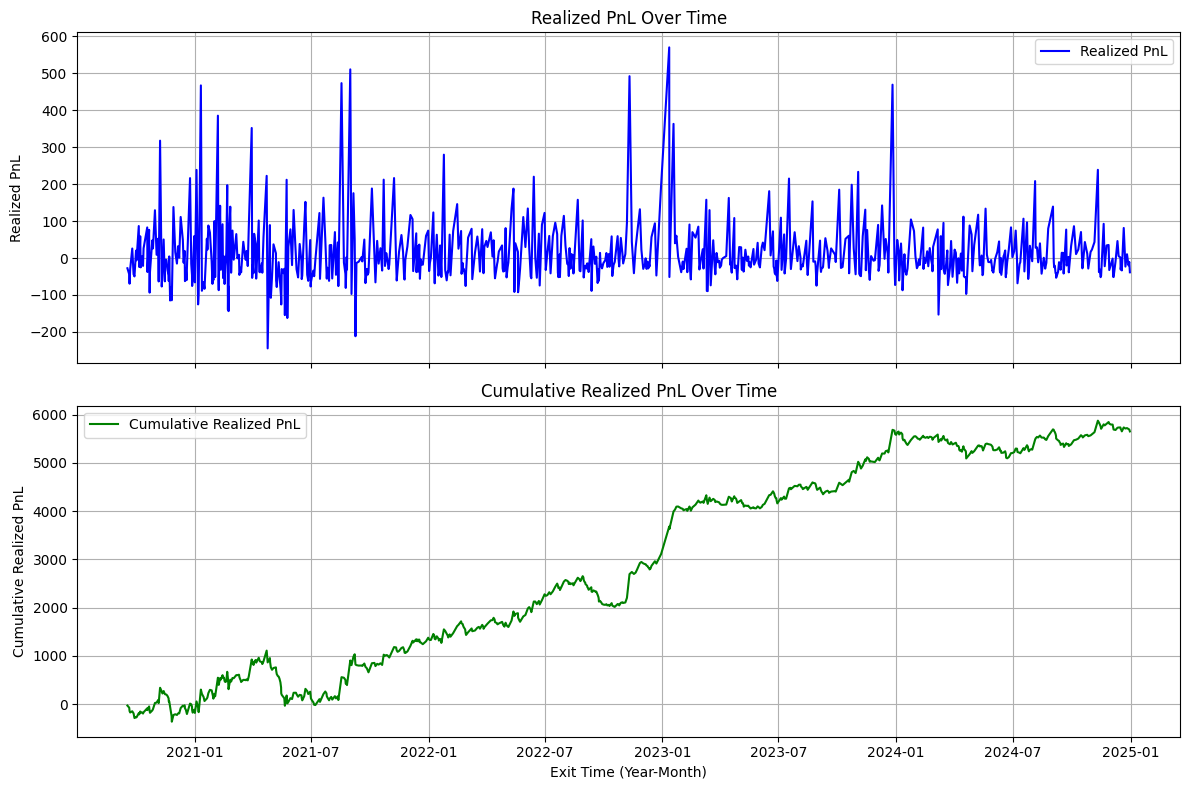

In [27]:
plot_realized_pnl(backtest_trade_sim)

# GET DATA

In [38]:
import requests
import pandas as pd
from datetime import datetime
from tqdm import tqdm

BINANCE_CANDLE_COLUMNS = ['opentime', 'openprice', 'highprice', 'lowprice', 'closeprice', 'volume', 'closetime',
                          'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused']

def binance_recursive_fetch_2(coins, interval, starttime, endtime, data_type='spot'):
    all_coins_result = {}
    data_list = []
    call_dict = {}
    
    for coin in tqdm(coins):
        result_list = []
        current_time = starttime
        call = 0
        timestamps = []
        
        while current_time < endtime:
            if ((int((endtime - current_time) / (1000 * 60))) + 1) >= 1000:
                limit = 1000
            else:
                limit = int((endtime - current_time) / (1000 * 60) + 1)
            
            if data_type == 'spot':
                url = (f'https://api.binance.com/api/v3/klines'
                       f'?symbol={coin}USDT'
                       f'&startTime={str(current_time)}'
                       f'&interval={interval}'
                       f'&limit={str(limit)}')
            elif data_type == 'futures':
                url = (f'https://fapi.binance.com/fapi/v1/klines'
                       f'?symbol={coin}USDT'
                       f'&startTime={str(current_time)}'
                       f'&interval={interval}'
                       f'&limit={str(limit)}')
            
            result_list += requests.get(url).json()
            
            if result_list:
                # Update current_time with the timestamp of the last data point fetched, plus 1 minute (60000 ms)
                current_time = result_list[-1][0] + 60000
                timestamps.append(current_time)
                call += 1
                
                # Check if the last fetched timestamp is greater than or equal to endtime
                if current_time >= endtime:
                    print(f"Reached endtime at {datetime.fromtimestamp(current_time / 1000).strftime('%Y-%m-%d %H:%M:%S')}. Stopping fetch.")
                    break
                
                print((datetime.fromtimestamp(current_time / 1000).strftime('%Y-%m-%d %H:%M:%S')) + 
                      f' status : {current_time < endtime}, time : {current_time}, limit : {call * 2}')
            
            # Ensure there's no continuous fetching of the same timestamp
            if len(timestamps) > 1 and timestamps[-1] == timestamps[-2]:
                print("Duplicate timestamp detected. Stopping fetch.")
                break
            
            # Sleep if needed to avoid rate limiting (adjust based on your rate limit)
            # time.sleep(0.1)  # Uncomment if needed
            
        current_df = pd.DataFrame(result_list, columns=BINANCE_CANDLE_COLUMNS)
        current_df['coin'] = coin
        current_df = current_df[['coin'] + BINANCE_CANDLE_COLUMNS]
        current_df = current_df.values.tolist()
        
        data_list += current_df
        call_dict.update({coin: call})
    
    return {'data': data_list, 'call': call_dict}

In [95]:
# Fetch COIN USDT
sample_spot = binance_recursive_fetch_2(
    ['SOL'],
    '1m',
    starttime=int(pd.to_datetime('2020-01-01 00:00', utc=True).timestamp() * 1000),
    endtime=int(pd.to_datetime('2024-12-31 23:59', utc=True).timestamp() * 1000),
    data_type='futures'  # Fetch spot data
)

# Define the column names for the DataFrame based on the Binance API response structure
columns = ['coin', 'opentime', 'openprice', 'highprice', 'lowprice', 'closeprice', 'volume', 'closetime', 
           'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused']

# Convert the list of data into a DataFrame
df = pd.DataFrame(sample_spot['data'], columns=columns)

# Drop unnecessary columns
df.drop(columns=(['coin','volume','closetime','quotevolume','trades','taker_buy_volume','taker_buy_quote','unused']), inplace=True)

# Convert columns 1-4 (openprice, highprice, lowprice, closeprice) to float
df[['openprice', 'highprice', 'lowprice', 'closeprice']] = df[['openprice', 'highprice', 'lowprice', 'closeprice']].apply(pd.to_numeric, errors='coerce')

# Show the first few rows of the DataFrame
df

  0%|          | 0/1 [00:00<?, ?it/s]

2020-09-14 23:40:00 status : True, time : 1600126800000, limit : 2
2020-09-15 16:20:00 status : True, time : 1600186800000, limit : 4
2020-09-16 09:00:00 status : True, time : 1600246800000, limit : 6
2020-09-17 01:40:00 status : True, time : 1600306800000, limit : 8
2020-09-17 18:20:00 status : True, time : 1600366800000, limit : 10
2020-09-18 11:00:00 status : True, time : 1600426800000, limit : 12
2020-09-19 03:40:00 status : True, time : 1600486800000, limit : 14
2020-09-19 20:20:00 status : True, time : 1600546800000, limit : 16
2020-09-20 13:00:00 status : True, time : 1600606800000, limit : 18
2020-09-21 05:40:00 status : True, time : 1600666800000, limit : 20
2020-09-21 22:20:00 status : True, time : 1600726800000, limit : 22
2020-09-22 15:00:00 status : True, time : 1600786800000, limit : 24
2020-09-23 07:40:00 status : True, time : 1600846800000, limit : 26
2020-09-24 00:20:00 status : True, time : 1600906800000, limit : 28
2020-09-24 17:00:00 status : True, time : 1600966800

100%|██████████| 1/1 [05:04<00:00, 304.35s/it]


,opentime,openprice,highprice,lowprice,closeprice
0,1600066800000,3.2002,4.9100,3.2002,3.2745
1,1600066860000,3.2731,3.3422,3.2709,3.3192
2,1600066920000,3.3193,3.3500,3.3132,3.3460
3,1600066980000,3.3318,3.3521,3.3150,3.3151
4,1600067040000,3.3151,3.3160,3.2725,3.3045
...,...,...,...,...,...
2260375,1735689300000,189.6700,189.9400,189.6100,189.7900
2260376,1735689360000,189.8000,189.8200,189.6000,189.6000
2260377,1735689420000,189.6100,189.6500,189.4100,189.4300
2260378,1735689480000,189.4300,189.5000,189.3000,189.3400


# BACKTEST

In [96]:
# Add supertrend indicator
supertrend_df = calculate_supertrend(df, length=10, multiplier=3.0)

# Add ichimoku indicator
supertrend_ichimoku_df = compute_ichimoku_with_supertrend(supertrend_df)

# Create position signal
backtest_trade_recap = generate_backtest_trade_recap(supertrend_ichimoku_df)

# Calculate the backtest
backtest_trade_sim, results = backtest_trade_summary(backtest_trade_recap)

# Show the statistics
results

{'Position Counts': {'long': 27429, 'short': 26934},
 'Position Percentages': {'long': 50.45527288780972,
  'short': 49.54472711219028},
 'Realized PnL Stats': {'max': np.float64(231.74574250681187),
  'min': np.float64(-105.59444844989193),
  'avg': np.float64(-0.3557779499469861),
  'median': np.float64(-2.301606117270028)},
 'Hold Time Stats': {'max': np.float64(6.533333333333333),
  'min': np.float64(0.016666666666666666),
  'avg': np.float64(0.569370711697294),
  'median': np.float64(0.43333333333333335)},
 'Overall Win Rate': np.float64(32.062248220296894),
 'Win Rate by Position': {'long': 32.410951912209704,
  'short': 31.707135961981137},
 'Cummulative_PnL': np.float64(-19341.156692968012),
 'Total Long + Short Trades': 54363}

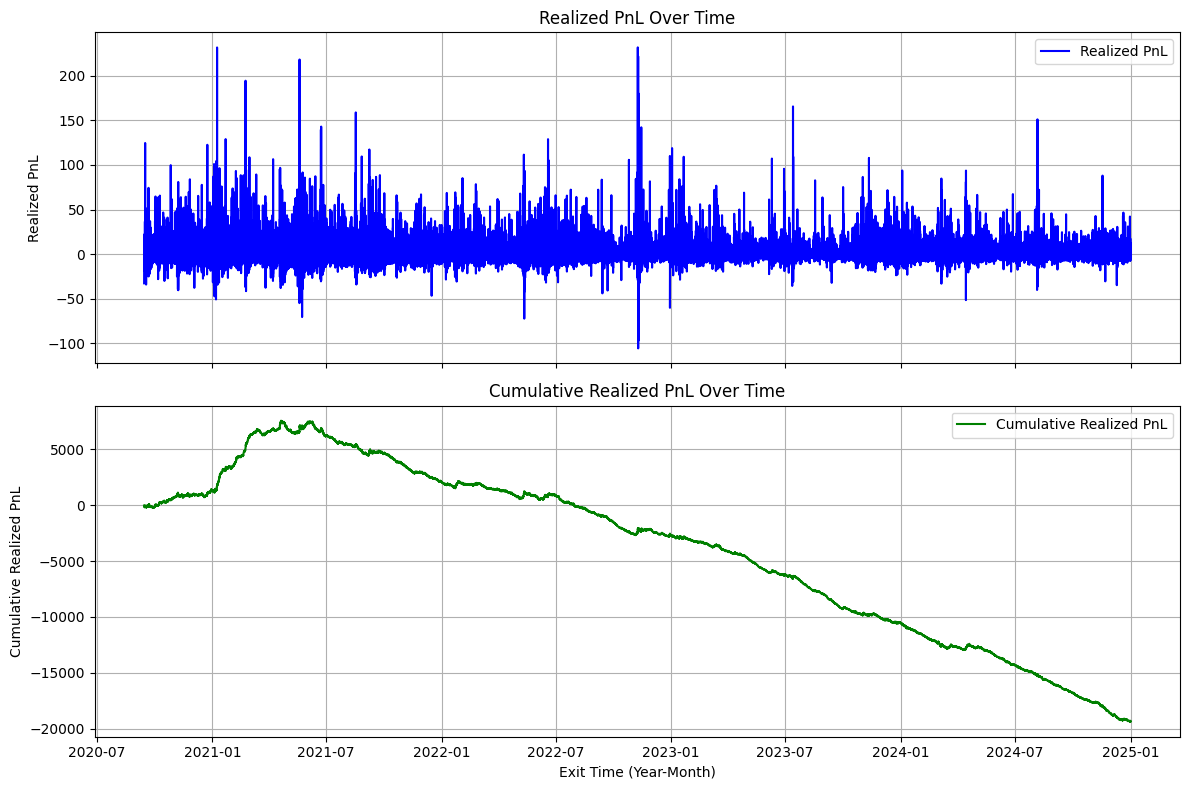

In [97]:
# Plot Cumullative pnl
plot_realized_pnl(backtest_trade_sim)